In [1]:
from emulator import *
from fisher_utils import *

In [2]:
fiducial_dndM(1, 3)

array([[2.32777096e-13]])

In [3]:
z_bin_edges = [0.2, 0.4, 0.6, 0.8, 1.0]
richness_bin_edges = [20., 30., 45., 60., 300.]

In [4]:
N_fiducial = N_in_z_bins_and_richness_bins(fiducial_cosmology, richness_bin_edges, z_bin_edges)

  0%|          | 0/4 [00:00<?, ?it/s]

Creating dndM interpolation



100%|██████████| 4/4 [03:06<00:00, 46.66s/it] 


In [5]:
cluster_count_cov = np.zeros((len(z_bin_edges) - 1, len(z_bin_edges) - 1, len(richness_bin_edges) - 1, len(richness_bin_edges) - 1))


In [6]:
halo_bias = ccl.halos.HaloBiasTinker10(fiducial_ccl_cosmo)

In [7]:
fiducial_h = fiducial_cosmology['H0']/100
halo_bias.get_halo_bias(fiducial_ccl_cosmo, 1e14 *  fiducial_h, 1) #[Mass] is Msun / h

1.5599995119337984

In [8]:
Ωs_rad**2

30.064534269753832

In [44]:
from scipy.integrate import quad, dblquad

def inner_integral(lam, M, z_val):
    p = cluster_richness_relation(M, lam, z_val)
    dn_dM = fiducial_dndM(z_val, M)
    bh = halo_bias.get_halo_bias(fiducial_ccl_cosmo, M * fiducial_h, 1./(1+z_val))
    return p * dn_dM  * bh

def outer_integral(z_val, lam_alpha_min, lam_alpha_max, lam_beta_min, lam_beta_max):
    integral_M_val, _ = dblquad(inner_integral, M_min, M_max, lam_alpha_min, lam_alpha_max,
                             args=(z_val,), 
                             epsrel=1e-4, epsabs=0)

    integral_M_prime_val, _ = dblquad(inner_integral, M_min, M_max, lam_beta_min, lam_beta_max,
                             args=(z_val,), 
                             epsrel=1e-4, epsabs=0)
    
    d2V_dzdOmega = comoving_volume_elements(z_val, tuple(fiducial_cosmo_vals))
    h = fiducial_cosmology['H0']/100
    Ωb =  fiducial_cosmology['ombh2'] / h**2
    Ωc =  fiducial_cosmology['omch2'] / h**2

    Ez = np.sqrt((Ωb+Ωc)*(1+z_val)**3 + (1-(Ωb+Ωc))) # unitless

    return Ωs_rad**2 * integral_M_val * integral_M_prime_val * d2V_dzdOmega**2 * Ez/DH







In [45]:
test, _ = quad(outer_integral, 
                         0.2, 0.4, 
                         args=(20, 30, 
                               20, 30),
                        epsrel=1e-4, epsabs=0)
print('%.1e'%(test))

1.6e+06


In [15]:
all_bin_combos = [[i,j,a,b] for i in range(len(z_bin_edges) - 1) 
 for j in range(len(z_bin_edges) - 1) 
 for a in range(len(richness_bin_edges) - 1)
for b in range(len(richness_bin_edges) - 1)]


for i,j,a,b in tqdm(all_bin_combos):
    zi_min = z_bin_edges[i]
    zi_max = z_bin_edges[i + 1]
    zj_min = z_bin_edges[j]
    zj_max = z_bin_edges[j + 1]
    #from Eq(6) of Krause+17, it seems like supersample variance only
    #when the redshift bins overlap. so we can ignore when
    #zi != zj
    if(i != j):
        continue
    la_min = richness_bin_edges[a]
    la_max = richness_bin_edges[a + 1]
    lb_min = richness_bin_edges[b]
    lb_max = richness_bin_edges[b + 1]
    result, error = quad(outer_integral, 
                         zi_min, zi_max, 
                         args=(la_min, la_max, 
                               lb_min, lb_max),
                        epsrel=1e-4, epsabs=0)
    cluster_count_cov[i,j,a,b] = result 
    if(i == j and a == b): #shot noise
        cluster_count_cov[i,j,a,b] +=  N_fiducial[i][a]


100%|██████████| 256/256 [06:50<00:00,  1.60s/it]


In [16]:
n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                cov_matrix_2d[row_index, col_index] = cluster_count_cov[i, j, a, b]


In [28]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'serif'


/tmp/ipykernel_27261/1613254133.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(cov_matrix_2d), cmap='rainbow')


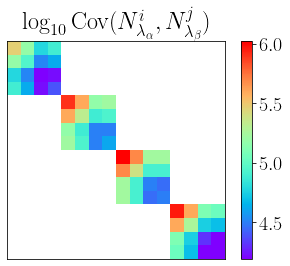

In [29]:
import matplotlib.pyplot as plt

plt.imshow(np.log10(cov_matrix_2d), cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'$\log_{10}{\rm Cov}(N^i_{\lambda_\alpha} , N^j_{\lambda_\beta})$')
plt.savefig('cluster_abundance_cov.pdf')

/tmp/ipykernel_27261/1283823288.py:3: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.sqrt(cov_matrix_2d)), cmap='rainbow')


([], [])

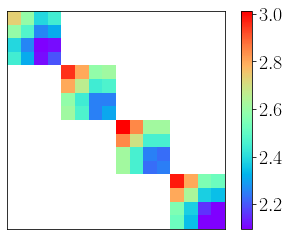

In [27]:
import matplotlib.pyplot as plt

plt.imshow(np.log10(np.sqrt(cov_matrix_2d)), cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
# plt.title(r'$\log_{10}{\rm Cov}(N^i_{\lambda_\alpha} , N^j_{\lambda_\beta})$')


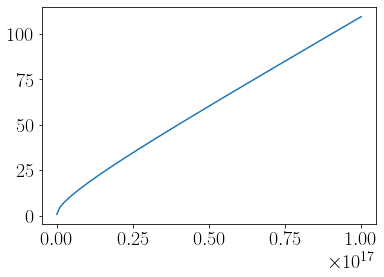

In [21]:
M_numerics = np.linspace(M_min, M_max, 100)
plt.plot(M_numerics, halo_bias.get_halo_bias(fiducial_ccl_cosmo, M_numerics *  fiducial_h, 1./(1+0.2))) #[Mass] is Msun / h

In [22]:
from scipy.integrate import dblquad
def inner_cluster_count_integrand(lam, M, z_val=0):
    p = cluster_richness_relation(M, lam, z_val) # h / Msun

    dn_dM = fiducial_dndM(z_val, M) # h^4 / (Mpc^3  Msun)

    return p * dn_dM  # h / (Msun)
dblquad(inner_cluster_count_integrand, M_min, M_max, 20, 30, epsrel=1e-4, epsabs=0)

(8.963540604845908e-06, 1.3531209359172206e-10)

In [23]:
dblquad(inner_integral, M_min, M_max, 20, 30, args=(0.0,), epsrel=1e-4, epsabs=0)

(8.963540604845908e-06, 1.3531209359172206e-10)

In [24]:
import pickle
    
with open('cluster_abundance_fiducial_covariance.pkl', 'wb') as file:
        pickle.dump(cluster_count_cov, file)

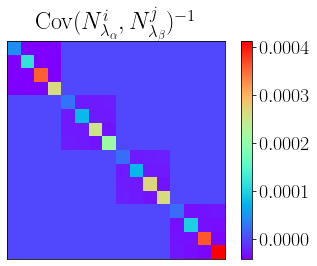

In [25]:
import matplotlib.pyplot as plt

plt.imshow((np.linalg.inv(cov_matrix_2d)), cmap='rainbow')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'${\rm Cov}(N^i_{\lambda_\alpha} , N^j_{\lambda_\beta})^{-1}$')
plt.show()

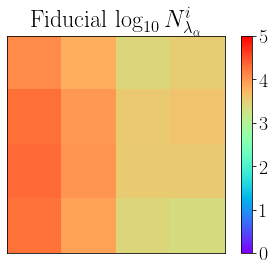

In [30]:
import matplotlib.pyplot as plt

plt.imshow(np.log10(N_fiducial), cmap='rainbow', vmin=0, vmax=5)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title(r'Fiducial $\log_{10} N^i_{\lambda_\alpha}$')
plt.savefig('fiducial_cluster_abundance.pdf')

In [46]:
n_z = len(z_bin_edges) - 1
n_r = len(richness_bin_edges) - 1
cov_matrix_2d_shot_noise_only = np.zeros((n_z * n_r, n_z * n_r))

for i in range(n_z):
    for j in range(n_z):
        for a in range(n_r):
            for b in range(n_r):
                row_index = i * n_r + a
                col_index = j * n_r + b
                if(i==j and a==b):
                    cov_matrix_2d_shot_noise_only[row_index, col_index] = N_fiducial[i][a]

In [49]:
all_bin_combos = [[i,j,a,b] for i in range(len(z_bin_edges) - 1) 
 for j in range(len(z_bin_edges) - 1) 
 for a in range(len(richness_bin_edges) - 1)
for b in range(len(richness_bin_edges) - 1)]

cluster_count_cov_shot_only = np.zeros((len(z_bin_edges) - 1, len(z_bin_edges) - 1, len(richness_bin_edges) - 1, len(richness_bin_edges) - 1))

for i,j,a,b in tqdm(all_bin_combos):
    if(i == j and a == b): #shot noise
        cluster_count_cov_shot_only[i,j,a,b] +=  N_fiducial[i][a]


100%|██████████| 256/256 [00:00<00:00, 1544952.26it/s]


In [50]:
import pickle
    
with open('cluster_abundance_fiducial_covariance_shot_noise_only.pkl', 'wb') as file:
        pickle.dump(cluster_count_cov_shot_only, file)